In [11]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import fish_models
import fish_models.utils
import robofish.io

In [12]:
fishes = 2

In [13]:
# A decision stump is a machine learning model consisting of a one-level decision tree.
# That is, it is a decision tree with one internal node (the root) 
# which is immediately connected to the terminal nodes (its leaves).

# For continuous features, usually, some threshold feature value is selected, 
# and the stump contains two leaves — for values below and above the threshold. 
class OneLevelDecisionTree():
    def __init__(self, feature_column, label_1, label_2, threshold=0):
        self.feature = feature_column
        self.label_1 = label_1
        self.label_2 = label_2
        self.threshold = threshold
        
    def predict(self, X):
        return np.where(X[:, self.feature] >= self.threshold, self.label_1, self.label_2)

In [21]:
import math
import random

class AdaBoostFishModel(fish_models.gym_interface.AbstractModel):
    def __init__(self, dset):
        """
        Parameters
        ---------

        """
        self.cls_boost = self.classifier_boost(dset[:]["views"])
        self.boost_size = 100
        self.classifiers = []
        self.weights = []
        print ("Weak: {} of type {}".format(len(self.cls_boost), type(self.cls_boost[0]).__name__))
        
    def classifier_boost(self, X):
        boost = []   
        # passing by columns
        # creates the same number of stumps as the number of features. 
        for feature in range(X.shape[1]):
            # get every unique feature in ordered way
            for threshold in sorted(set(X[:, feature])):
                boost += [
                    OneLevelDecisionTree(feature, 1, -1, threshold)]                  
        return boost
    
    
    def compute_error(self, preds):
        for i in range(len(preds)):
            if preds[i] != self.y[i]:
                self.error.append(self.weights[i])
            else:
                continue
    
    def fit_train(self, dset): 
        X = dset[:]["views"]
        y = dset[:]["actions"]
        # Step 1
        # initialise w_i = 1/N for all i from [1..N]
        w = np.full_like(y, 1/len(y))
        
        # with the 1/N the each weight is too small = 0.00028986
        # trying with 1 as a initial weight
        # w = np.ones(len(y))
        
        # P.S: it does not change the predictions
        # the np.log in alpha should be with minus sign

        # Step 2.a - 1
        # for m from [1..M] of boost size
        # train a classifier f_m(x) -> [-1, 1] on X
        # and save all errors
        # diffs.shape:  (13292, 3450)
        diffs = np.array([clf.predict(X) != y for clf in self.cls_boost])
 
        for m in range(self.boost_size):                   
            # Step 2.b
            # Compute classification error    
            errors = diffs @ w

            # indix of the minimum values
            min_err_idx = np.argmin(errors)
            
            # collect classifiers
            self.classifiers += [self.cls_boost[min_err_idx]]
            
            # from lecture: sum of all the weights that were missclassified 
            # devided by the sum of all weights
            w_err = errors[min_err_idx]
            w_sum = w.sum()

            # The total error is the sum of all the errors in the classified record for sample weights.
            E_m = (w_sum - w_err) / w_sum

            # Step 2.c
            # Compute classifier weight

            # Formula for calculating Performance of Stump 
            alpha_m = -0.5 * np.log((1 - E_m) / E_m)

            # Step 2.d
            # Recompute sample weights
            self.weights += [alpha_m]
            
            # we must update the sample weight before proceeding for the next model or stage 
            # because if the same weight is applied, we receive the output from the first model.
            
            # For incorrectly classified records the formula is:
            # New Sample Weight = Sample Weight * e^(Performance) 
            # And for correctly classified records, we use the same formula with a negative sign with performance, 
            # so that the weight for correctly classified records will reduce compared to the incorrect classified ones. 
            # New Sample Weight = Sample Weight * e^- (Performance)
            
            # self.weights[-1] is the weight for correctly classified records after it was added into array
            # returns all indixes of the given row
            # non-zero values will be 1
            # zero values will be -1
            w = w * np.exp(np.where(diffs[min_err_idx], 1, -1) * self.weights[-1])
            
            diffs = np.delete(diffs, min_err_idx, axis=0)
            del self.cls_boost[min_err_idx]
            
            #print("debug: done m = ", m)

        # convert into numpy array
        #print("debug: done.")
        self.weights = np.array(self.weights)

        
    def choose_action(self, view: np.ndarray):
        """
        Predict regression target for given view of a virtual fish.
        The predicted regression target of an input sample is computed 
        as the mean predicted regression targets of the trees in the forest.
        """
        
        prediction = self.clf.predict([view])
        
        speed = prediction[0][0]
        turn = prediction[0][1]
        
        # turn correction for walls avoidance
        #turn = self.avoid_walls(view, turn)
        
        return speed, turn
        
    
    def predict(self, X):
        preds = np.array([cl.predict(X) for cl in self.classifiers])
        weighted_preds = np.dot(self.weights, preds)
        return np.where(weighted_preds >= 0, 1, -1)


In [14]:
raycast = fish_models.gym_interface.Raycast(
            n_wall_raycasts=5,
            n_fish_bins=4,
            fov_angle_fish_bins=np.pi,
            fov_angle_wall_raycasts=np.pi,
            world_bounds=([-50, -50], [50, 50]),
        )



In [15]:
data_folder = Path("data/live_female_female/train")

dset = fish_models.datasets.io_dataset.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    reduce_dim=2,
    max_files=1,
)

  0%|          | 0/1 [00:00<?, ?it/s]

Loading data from 1 files.


  0%|          | 0/1 [00:00<?, ?it/s]

Calculating views from 1 files.


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

Status of IoDataset:
The first 3 dimensions are reduced from (1, 2, 8990) to (17980)
poses	(17980, 3):	consisting of x, y, orientation.
actions	(17978, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(17978, 9):	4 fish_bins and 5 wall ray casts.



In [22]:
model = AdaBoostFishModel(dset)

Weak: 98420 of type OneLevelDecisionTree


In [17]:
model.fit_train(dset)

ValueError: Unknown label type: 'continuous-multioutput'

In [7]:
generator = fish_models.gym_interface.TrackGeneratorGym(
    model, dset.world_size, dset.frequency, raycast=raycast
)

track = generator.create_track(n_guppies=fishes, trackset_len=1000)

100%|██████████| 999/999 [00:56<00:00, 17.73it/s]


In [8]:

f = generator.as_io_file(track)
f.save_as("output/random_forest.hdf5")

<HDF5 file "793196c1-fdbd-40fa-b487-568261c9ffb1" (mode r+)>

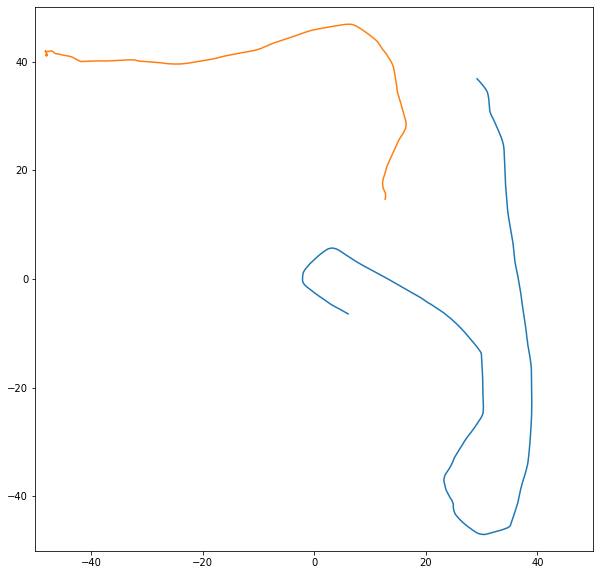

In [9]:
plt.figure(figsize=(10,10))
plt.xlim(-50,50)
plt.ylim(-50,50)
for fish_id in range(fishes):
    plt.plot(track[fish_id, :, 0], track[fish_id, :, 1])
plt.show()

In [12]:
def trajectory_generator(model_name, model, raycast, dset):
    generator = fish_models.gym_interface.TrackGeneratorGym(
    model, dset.world_size, dset.frequency, raycast=raycast
    )
    # Generate raycast file
    # initial_poses = dset.poses[0, :, 0]
    for i in range(20):
        timesteps = 1500
        initial_poses = np.array([[0.0, 0.0, 0.0], [0.0, 3.0, 0.0]])
        track = generator.create_track(2, timesteps, initial_poses=initial_poses)
        f = generator.as_io_file(track)
        f.save_as("output/{}_modeldata/__generated{}.hdf5".format(model_name, str(i)))

In [13]:
trajectory_generator("RandomForestRegressor", model, raycast, dset)

  1%|          | 17/1499 [00:01<01:36, 15.29it/s]


KeyboardInterrupt: 